In [3]:
import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
from sklearn.model_selection import KFold

In [5]:
from create_matrix import *

from tensor_custom_core import *
from create_matrix import *
from tensor_custom_core import *
from degree_days import dds
appliance_index = {appliance: APPLIANCES_ORDER.index(appliance) for appliance in APPLIANCES_ORDER}

APPLIANCES = ['fridge', 'hvac', 'wm', 'mw', 'oven', 'dw']
region = "Austin"
year = 2014

import os


def un_normalize(x, maximum, minimum):
    return (maximum - minimum) * x + minimum

In [6]:
import sys
case=2
a=2
cost='abs'

In [7]:
def get_tensor(df, dfc):
    start, stop = 1, 13
    energy_cols = np.array(
        [['%s_%d' % (appliance, month) for month in range(start, stop)] for appliance in APPLIANCES_ORDER]).flatten()

    static_cols = ['area', 'total_occupants', 'num_rooms']
    static_df = df[static_cols]
    static_df = static_df.div(static_df.max())
    weather_values = np.array(dds[2014][region][start - 1:stop - 1]).reshape(-1, 1)

    dfc = df.copy()

    df = dfc[energy_cols]
    col_max = df.max().max()
    col_min = df.min().min()
    # df = (1.0 * (df - col_min)) / (col_max - col_min)
    tensor = df.values.reshape((len(df), 7, stop - start))
    M, N, O = tensor.shape
    return tensor

In [8]:
au_df, au_dfc = create_matrix_single_region(region, year)
au_tensor = get_tensor(au_df, au_dfc)

### Learning H, A, T from Austin

In [9]:
H_a, A_a, T_a = learn_HAT(case, au_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost) 

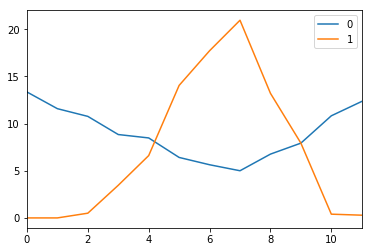

In [10]:
pd.DataFrame(T_a).plot();

In [11]:
sd_df, sd_dfc = create_matrix_single_region("SanDiego", year)

In [12]:
kf = KFold(n_splits=2)

### Transfer learning with A_au

In [46]:
from scipy.optimize import nnls

pred = {}
sd = {}
out = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'
for appliance in APPLIANCES_ORDER:
    pred[appliance] = {f:[] for f in range(10, 110, 10)}
print pred

kf = KFold(n_splits=n_splits)
for adapt_percentage in range(10, 110, 10):
    print adapt_percentage, "\n"
    count = 0
    for adapt_max, test in kf.split(sd_df):
        print "round ", count
        count = count + 1
        
        
        # use the top *% as adapt data to learn S_sd
        num_adapt = int((adapt_percentage * len(adapt_max)/100) + 0.5)
        adapt = adapt_max[:num_adapt]

        adapt_ix = sd_df.index[adapt]
        test_ix = sd_df.index[test]
        num_test = len(test_ix)

        # use the adpat data with A_au from Austion to learn T_sd_adapt
        adapt_df = sd_df.ix[adapt_ix]
        test_df = sd_df.ix[test_ix]
        adapt_dfc = sd_dfc.ix[adapt_ix]
        test_dfc = sd_dfc.ix[test_ix]
        adapt_sd_tensor = get_tensor(adapt_df, adapt_dfc)

        H_sd_adapt, A_sd_adapt, T_sd_adapt = learn_HAT(case, adapt_sd_tensor, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)

        # Then we use T_sd_adapt, A_a and aggregate readings to learn H_sd in SanDiego
        test_sd_tensor = get_tensor(test_df, test_dfc)
        # Get the aggregate information of test homes
        aggregate_test = test_sd_tensor[:, 0, :]

        # Use A_au from Austin and T_sd_adapt learn previous
        AT_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_adapt)

        # Estimate Home factor H_test_mat for test homes
        H_test_mat = np.zeros((len(test_df), 2))

        for j in range(len(test_df)):
            mask_rows = pd.Series(aggregate_test[j,:]).notnull()
            H_test_mat[j,:] = nnls(AT_mat.transpose()[mask_rows], aggregate_test[j,:][mask_rows])[0]
        pred_overall = np.einsum('Ma, Nab, Ob -> MNO', H_test_mat, A_a, T_sd_adapt)

        
        for appliance_name, appliance_id in appliance_index.iteritems():
            pred[appliance_name][adapt_percentage].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
#         print pred

{'hvac': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'wm': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'fridge': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'mw': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'oven': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'aggregate': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}, 'dw': {100: [], 70: [], 40: [], 10: [], 80: [], 50: [], 20: [], 90: [], 60: [], 30: []}}
10 

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9
20 

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9
30 

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7
round  8
round  9
40 

round  0
round  1
round  2
round  3
round  4
round  5
round  6
round  7

In [47]:
# pred['hvac'][10]
pd.concat(pred['hvac'][10]).ix[sd_df.index]
for appliance_name, appliance_id in appliance_index.iteritems():
    for adapt_percentage in range(10, 110, 10): 
        pred[appliance_name][adapt_percentage] = pd.concat(pred[appliance_name][adapt_percentage]).ix[sd_df.index]

In [48]:
from common import compute_rmse_fraction

In [49]:
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    out[appliance] = {}
    print appliance
    for adapt_percentage in range(10, 110, 10): 
        if appliance=="hvac":
            out[appliance][adapt_percentage] = compute_rmse_fraction(appliance, pred[appliance][adapt_percentage][range(4, 10)],'SanDiego')[2]
        else:   
            out[appliance][adapt_percentage] = compute_rmse_fraction(appliance, pred[appliance][adapt_percentage],'SanDiego')[2]

hvac
fridge
mw
dw
wm
oven


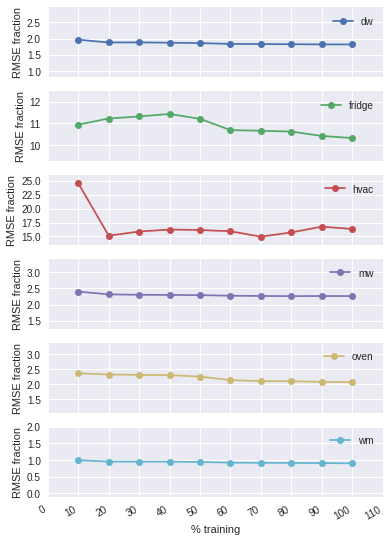

In [50]:
import seaborn
ax = pd.DataFrame(out).plot(subplots=True, figsize=(6, 10),marker='o',xlim=(0, 110))
ax[-1].set_xlabel("% training");
ax[-1].locator_params(tight=False, nbins=20, axis='x')
for a in ax:
    a.locator_params(tight=False, nbins=6, axis='y')
    yl_start, yl_end  = a.get_ylim()
    a.set_ylim((yl_start-1, yl_end+1))
    a.set_ylabel("RMSE fraction")
# plt.savefig("../results/sd_transfer_error_vs_train_fraction.png", bbox_inches="tight", dpi=300)

### Normal learning for SanDiego

In [37]:
pred_normal = {}
sd = {}
out_normal = {}
n_splits = 10
case = 2
a = 2
cost = 'abs'
for appliance in APPLIANCES_ORDER:
    pred_normal[appliance] = {f:[] for f in range(10, 110, 10)}

kf = KFold(n_splits=n_splits)
for train_percentage in range(10, 110, 10):
    print train_percentage, "\n"
    for train_max, test in kf.split(sd_df):
        
        num_train = int((train_percentage*len(train_max)/100)+0.5)
        train = train_max[:num_train]
        
        train_ix = sd_df.index[train]
        test_ix = sd_df.index[test]
        num_test = len(test_ix)
        train_test_ix = np.concatenate([test_ix, train_ix])
        df_t, dfc_t = sd_df.ix[train_test_ix], sd_dfc.ix[train_test_ix]
        tensor = get_tensor(df_t, dfc_t)
        tensor_copy = tensor.copy()
        # First n
        tensor_copy[:num_test, 1:, :] = np.NaN
        H, A, T = learn_HAT(case, tensor_copy, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost)
        HAT = multiply_case(H, A, T, case)
        print train_ix, test_ix
        for appliance in APPLIANCES_ORDER:
#             print appliance
            pred_normal[appliance][train_percentage].append(pd.DataFrame(HAT[:num_test, appliance_index[appliance], :], index=test_ix))
        

10 

Int64Index([1524, 1731, 2031], dtype='int64') Int64Index([54, 203, 527, 1450], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([1524, 1731, 2031, 2354], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([2606, 3687, 3864, 3938], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([4083, 4095, 4329, 4495], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([4761, 4934, 5909, 5938], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([6268, 6377, 6429, 6497], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([6547, 7062, 7114, 7409], dtype='int64')
aggregate
hvac
fridge
mw
dw
wm
oven
Int64Index([54, 203, 527], dtype='int64') Int64Index([7639, 8061, 8342, 8574], dtype=

In [39]:
out_normal = {}
for appliance in APPLIANCES_ORDER[1:]:
    out_normal[appliance] = {}
    for f in range(10, 110, 10):
        s = pd.concat(pred_normal[appliance][f]).ix[sd_df.index]
        if appliance=="hvac":
            out_normal[appliance][f] = compute_rmse_fraction(appliance,s[range(4, 10)],'SanDiego')[2]
        else:   
            out_normal[appliance][f] = compute_rmse_fraction(appliance, s,'SanDiego')[2]

    

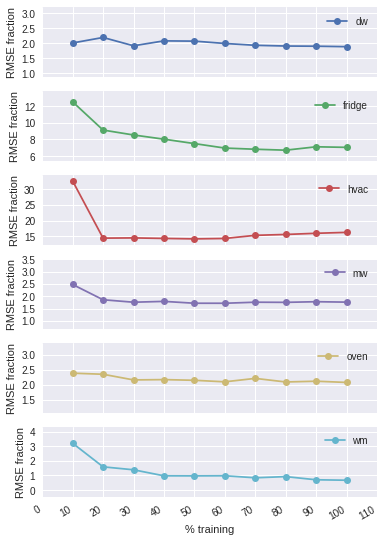

In [98]:
import seaborn
ax = pd.DataFrame(out_normal).plot(subplots=True, figsize=(6, 10),marker='o',xlim=(0, 110))
ax[-1].set_xlabel("% training");
ax[-1].locator_params(tight=False, nbins=20, axis='x')
for a in ax:
    a.locator_params(tight=False, nbins=6, axis='y')
    yl_start, yl_end  = a.get_ylim()
    a.set_ylim((yl_start-1, yl_end+1))
    a.set_ylabel("RMSE fraction")
# plt.savefig("../results/sd_error_vs_train_fraction.png", bbox_inches="tight", dpi=300)

In [113]:
df_out_normal = pd.DataFrame(out_normal)
df_out_normal = df_out_normal.rename(columns={'dw':'dw_normal', 'fridge':'fridge_normal', 'hvac':'hvac_normal',
                                             'mw':'mw_normal', 'oven':"oven_normal", 'wm':'wm_normal'})
df_out = pd.DataFrame(out)
df_out = df_out.rename(columns={'dw':'dw_transfer', 'fridge':'fridge_transfer', 'hvac':'hvac_transfer',
                                             'mw':'mw_transfer', 'oven':"oven_transfer", 'wm':'wm_transfer'})
df_out_normal

all_out = pd.concat([df_out, df_out_normal], axis=1)
all_out

,dw_transfer,fridge_transfer,hvac_transfer,mw_transfer,oven_transfer,wm_transfer,dw_normal,fridge_normal,hvac_normal,mw_normal,oven_normal,wm_normal
10,1.965080,10.940841,24.558019,2.398502,2.361291,0.996276,2.007011,12.482075,32.588746,2.475164,2.386913,3.203851
20,1.879253,11.222647,15.134262,2.313002,2.322064,0.953741,2.190485,9.114440,14.392639,1.855483,2.350019,1.589023
30,1.881829,11.318499,15.885578,2.300310,2.309428,0.952466,1.912748,8.528117,14.464357,1.755400,2.160699,1.387317
40,1.871909,11.431717,16.238547,2.296104,2.301429,0.951126,2.076363,8.026768,14.299636,1.789309,2.171112,0.975831
50,1.859370,11.208639,16.157509,2.289426,2.250872,0.942402,2.068123,7.501864,14.157035,1.714046,2.148128,0.970900
60,1.834985,10.687206,15.932691,2.271587,2.136779,0.921073,1.990046,6.966252,14.285349,1.713450,2.097105,0.979164
70,1.830876,10.658536,14.960932,2.263813,2.100412,0.917804,1.928660,6.826367,15.285635,1.756021,2.211702,0.840364
80,1.825019,10.621306,15.717818,2.259182,2.097927,0.914254,1.904354,6.714805,15.561853,1.750086,2.092263,0.920937
90,1.820113,10.419912,16.755838,2.262402,2.076533,0.908435,1.898361,7.117901,15.936011,1.776153,2.117308,0.704279
100,1.818491,10.322608,16.341788,2.261819,2.063225,0.903011,1.882632,7.051506,16.226711,1.759001,2.076530,0.673275


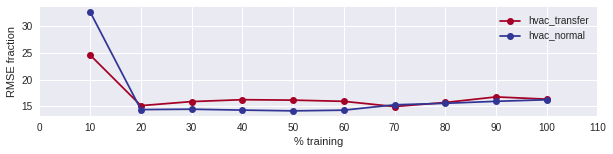

In [122]:
df1 = all_out['hvac_transfer']
df2 = all_out['hvac_normal']
df = pd.concat([df1, df2], axis=1)
ax = pd.DataFrame(df).plot(figsize=(10, 2), marker='o', xlim=(0, 110), colormap='RdYlBu')

major_ticks = np.arange(0, 101, 20)   

ax.set_xlabel("% training");
ax.locator_params(tight=False, nbins=20, axis='x')
ax.set_ylabel('RMSE fraction')

In [68]:
from scipy.optimize import nnls
pred = {}
for appliance_name, appliance_id in appliance_index.iteritems():
    pred[appliance_name] = []

for train, test in kf.split(sd_df):
    train_ix = sd_df.index[train]
    test_ix = sd_df.index[test]
    
    # Learning T from train SD homes, using A_a from Austin as known
    train_df = sd_df.ix[train_ix]
    test_df = sd_df.ix[test_ix]
    test_dfc = sd_dfc.ix[test_ix]
    train_dfc = sd_dfc.ix[train_ix]
    t_sd_train = get_tensor(train_df, train_dfc)
    H_sd_train, A_sd_train, T_sd_train = learn_HAT(case, t_sd_train, a, a, num_iter=2000, lr=0.1, dis=False, cost_function=cost, A_known=A_a)
    
    # Now, for the test homes, we will use T_sd_train and A_a and aggregate data to learn H_sd_test
    t_sd_test = get_tensor(test_df, test_dfc)
    # Refer to https://nipunbatra.github.io/blog/2017/nmf-nnls.html for NNLS and the variable names used
    
    # A_mat contains GT aggregate power
    A_mat = t_sd_test[:, 0, :]
    # H_mat is the "known"
    H_mat = np.einsum('ab, Ob -> aO', A_a[0], T_sd_train)
    M = len(test_df)
    # We want to estimate W_mat (Home factor); which we do using NNLS
    W_mat = np.zeros((M, 2))
    
    for j in range(M):
        mask_rows = pd.Series(A_mat[j,:]).notnull()
        W_mat[j,:] = nnls(H_mat.transpose()[mask_rows], A_mat[j,:][mask_rows])[0]
    pred_overall = np.einsum('Ma, Nab, Ob -> MNO', W_mat, A_a, T_sd_train)
    
    for appliance_name, appliance_id in appliance_index.iteritems():
        pred[appliance_name].append(pd.DataFrame(pred_overall[:,appliance_id,:], index=test_df.index))
for appliance_name, appliance_id in appliance_index.iteritems():
    pred[appliance_name] = pd.concat(pred[appliance_name]).ix[sd_df.index]
    

TypeError: 'AxesSubplot' object cannot be interpreted as an index

In [22]:
pred['mw'][10].head()

,0,1,2,3,4,5,6,7,8,9,10,11
54,2.547684,1.683476,1.652786,2.454354,2.972289,2.173384,2.436214,2.431206,3.200995,2.562801,2.391665,2.079165
203,2.563091,1.693715,1.662789,2.468937,2.987036,2.186064,2.442667,2.436377,3.210827,2.575484,2.405889,2.091352
527,3.008620,1.988438,1.951863,2.896671,3.488549,2.563508,2.821847,2.807601,3.716700,3.007718,2.822776,2.452753
1450,5.965360,3.941834,3.869973,5.746826,6.959516,5.088936,5.704225,5.692477,7.494926,6.000714,5.600040,4.868325
1524,0.304440,1.398746,4.921017,6.007669,5.360389,4.674684,4.877566,2.434703,1.164833,3.263120,3.215053,4.529615


In [14]:
from common import compute_rmse_fraction

In [24]:
out = {}
for appliance in APPLIANCES_ORDER[1:]:
    print appliance
    if appliance=="hvac":
        out[appliance] = compute_rmse_fraction(appliance, pred[appliance][range(4, 10)],'SanDiego')[2]
    else:   
        out[appliance] = compute_rmse_fraction(appliance, pred[appliance],'SanDiego')[2]

hvac
fridge
mw
dw
wm
oven


In [25]:
pd.Series(out)

dw         2.109064
fridge     9.002331
hvac      18.643008
mw         3.075347
oven       4.256726
wm         1.144493
dtype: float64

In [26]:
pred[appliance]

,0,1,2,3,4,5,6,7,8,9,10,11
54,8.846693,8.039534,8.355256,7.798724,7.853051,6.969353,7.729785,7.986466,9.402193,9.219779,8.752246,9.867527
203,11.500691,10.451386,10.875964,10.157539,10.261099,9.106708,10.130045,10.475423,12.314308,12.024519,11.381722,12.827774
527,21.830109,19.838362,20.599690,19.220034,19.312751,17.139146,18.971942,19.590653,23.086057,22.702018,21.592268,24.349119
1450,21.657700,19.681684,20.454498,19.092006,19.224750,17.061400,18.922756,19.551051,23.016921,22.570758,21.426454,24.156815
1524,21.415447,19.461534,20.256178,18.919845,19.122087,16.970900,18.886385,19.532852,22.956597,22.401948,21.195003,23.886609
1731,17.185350,15.617385,16.241238,15.163911,15.293997,13.573186,15.076306,15.583644,18.332636,17.939033,17.004722,19.168394
2031,8.432494,7.663126,7.976023,7.449832,7.529466,6.682420,7.436657,7.691208,9.039334,8.820936,8.345693,9.405533
2354,16.145354,14.672276,15.247440,14.231391,14.328131,12.715776,14.101036,14.568628,17.152466,16.823406,15.972709,18.008392
2606,14.201220,12.905522,13.414980,12.522550,12.615913,11.196307,12.423496,12.837721,15.110035,14.807374,14.050321,15.839921
3687,15.442553,14.033598,14.578457,13.604748,13.685006,12.144917,13.456920,13.899803,16.371747,16.076628,15.276003,17.224493


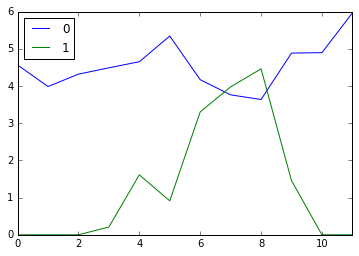

In [31]:
pd.DataFrame(T_sd_train).plot()

In [32]:
from degree_days import dds

In [36]:
dds[2014]['SanDiego']

[0.08259212198221093,
 0.0698856416772554,
 0.17280813214739518,
 0.20584498094027953,
 0.38373570520965694,
 0.33290978398983484,
 0.5438373570520966,
 0.5501905972045743,
 0.5997458703939009,
 0.47522236340533675,
 0.22363405336721728,
 0.08767471410419314]

In [37]:
df_corr = pd.DataFrame(T_sd_train)

In [39]:
df_corr['weather'] = dds[2014]['SanDiego']

In [41]:
df_corr.corr()

,0,1,weather
0,1.000000,-0.585948,-0.442960
1,-0.585948,1.000000,0.926306
weather,-0.442960,0.926306,1.000000
